### JRC algorithm - implementation for WSF2019population dataset

### <b>Urban delineation<b>
This notebook uses a JRC algorithm (GHSL settlement model) as defined by the stage I of the Degree of Urbanisation (European Commission & Statistical Office of the European Union, 2021) and recommended by the UN STAT COM.

This notebook implements algorithm for WSF2019population dataset (DLR) with resolution 10m.

WSF2019population dataset is provided by DLR (German Aerospace Center). This dataset describes the spatial distribution of the human population.

**Source data: WSF2019population**<br>
Available for countries: **Bolivia, Chile, Kenya and Myanmar**

Reference years: 2019<br>
Resolution: 10m<br>
Coord. system: WPSG=4326 <br>
<br>

#### <b>Load libraries:<b>

In [1]:
# !pip install rioxarray
# !pip install ipython-autotime
# !pip install folium
# !pip install ipywidgets

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from xcube.core.store import new_data_store

import os
from glob import glob
from pathlib import Path

import numpy as np
import xarray as xr
import rasterio.features
import rioxarray as rxr

import skimage
# from skimage import morphology
# from skimage import segmentation
from skimage.morphology import square

# import scipy
from scipy import ndimage

import shapely
from shapely.geometry import Polygon, box
# import fiona
import pandas as pd
import geopandas as gpd

# import pyproj
# from pyproj import CRS
import utm
# from osgeo import gdal  #for information about image

In [4]:
import folium
from folium import plugins
from branca.element import Figure

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
#import hvplot.xarray  # for interactive maps
from matplotlib.projections import register_projection
# import ipywidgets as widgets

In [6]:
# checking a processing time:
import datetime
import time
start_time = datetime.datetime.now().time().strftime('%H:%M:%S')

#### <b>Area of interest<b>

<ul>  
<li>Country - select one from ['Bolivia', 'Chile', 'Kenya', 'Myanmar'] : country  </li>
<li>Area of interest - bounding box of selected city within country : aoi </li>
</ul>

#### <b>Parameters<b>

<ul>   
<li>Threshold for Minimum Area (in pixels) of Urban Patches : THR_UPA </li>
    = minimal area (in pixels) for Urban Patches created with connectivity functions
<li>Threshold for Total Population in  Urban Patches : THR_UPP </li> 
<li>Threshold for Filling Holes (in pixels) of Urban Patches : THR_GAP </li>  
</ul>

In [7]:
# Default parameters which will be overwritten by the 
# actual parameters below
# 1 x 1pix =~ 10 x 10m
# 10 x 10pix =~ 100 x 100m = 1ha (100pix)
# 100 x 100pix =~ 1000 x 1000m = 1km2 (10.000pix)

# country = 'Bolivia'
# # Cochabamba (Bolivia)  (-66.4,-17.55, -65.8,-17.25)  # 3 minutes 
# aoi = "POLYGON ((-65.9 -17.55, -65.9 -17.25, -66.4 -17.25, -66.4 -17.55, -65.9 -17.55))"
country = 'Bolivia'
# Santa Cruz de la Siera (Bolivia):  box(-63.3,-18, -63,-17.65) # 2 minutes 
aoi = "POLYGON ((-63.3 -18, -63.3 -17.65, -63 -17.65, -63 -18, -63.3 -18))"
# country = 'Bolivia'
# # La Paz (Bolivia):  box(-68.4,-16.7, -68,-16.4) 
# aoi = "POLYGON ((-68.4 -16.7, -68.4 -16.4, -68 -16.4, -68 -16.7, -68.4 -16.7))"
# -----------------
# country = 'Chile'
# # Santiago (Chile)  (-71,-33.8, -70.4,-33.2)  19 minutes
# aoi = "POLYGON ((-71 -33.8, -71 -33.2, -70.4 -33.2, -70.4 -33.8, -71 -33.8))"
# country = 'Chile'
# # Valparaiso (Chile)  (-71.8,-33.4, -71.2,-32.8)  # coast  19 minutes (lat,lon  0.6 x 0.6 = max  for RAM = 8GB)
# aoi = "POLYGON ((-71.8 -33.4, -71.8 -32.8, -71.2 -32.8, -71.2 -33.4, -71.8 -33.4))"

# Nairobi (Kenya): box(36.6,-1.4, 37.2 ,-1.05)

# # DEFAULT VALUES for Urban Patches:
# # THR_UPA = 100000 # (=~ 10km2)
# THR_UPA = 30000 # (50000 =~ 5km2)
# THR_UPP = 5000 # (100000 = cities with population >=100000 people)
# THR_GAP = 5000  # (50000 =~ 5km2)

# DEFAULT VALUES for Urban Patches:
# THR_UPA = 100000 # (=~ 10km2)
THR_UPA = 50000 # (50000 =~ 5km2)
THR_UPP = 100000 # (100000 = cities with population >=100000 people)
THR_GAP = 50000  # (50000 =~ 5km2)

#### <b>Constants<b>
<li>Threshold for population density of WSF2019populationdataset: THR_POP </li>
<li>SQUARE matrix for binary morphological operation: SQR </li>  

In [8]:
# less value results in smaller patches of urban areas (splitted by roads etc.)
SQR=7 # recomended

#### <b>fix parameters<b>

In [9]:
# Threshold for total population WSF2019_population  (10m data - do not make sense to set-up different threshold)
THR_POP=0
# Reference year = 2019
REF_year=2019

##### <b>StopExecution class

In [10]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
# raise StopExecution

#### <b>Check aoi<b>  

In [11]:
# AOI
# check selected aoi:
from shapely import wkt
import geopandas as gpd

polygon = wkt.loads(aoi)
# bbox = polygon.bounds
# bbox

AOI = gpd.GeoDataFrame({"id":1,"geometry":[polygon]})
AOI.set_crs(epsg=4326, inplace=True)  # WGS84

,id,geometry
0,1,"POLYGON ((-63.30000 -18.00000, -63.30000 -17.6..."


In [12]:
AOI.centroid.x

0   -63.15
dtype: float64

In [13]:
fig = Figure(width=400, height=400)

m = AOI.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

lat_interval = 1
lon_interval = 1

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridians:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

fig.add_child(m)
m

### <b>Input data<b>

#### Open WSF2019population (data available only for Bolivia, Chile, Kenya and Myanmar)

In [14]:
POP_data_store = new_data_store("s3", 
                            root="xcube-dcfs/WSF2019population/",
                            storage_options=dict(anon=True)
                           )

In [15]:
POP_data_store_info=list(POP_data_store.get_data_ids())
POP_data_store_info

['Bolivia_WSF2019population_WSF3D.tif',
 'Chile_WSF2019population_WSF3D.tif',
 'Kenya_WSF2019population_WSF3D.tif',
 'Myanmar_WSF2019population_WSF3D.tif']

In [16]:
# Select population data for Reference year
POP_country= '\n'.join(s for s in POP_data_store_info if country in s)
POP_country

'Bolivia_WSF2019population_WSF3D.tif'

In [17]:
# Info about WSF2019population data for country

# POP_data_store.describe_data(POP_country).to_dict()
print(POP_data_store.describe_data(POP_country).data_id)
print(POP_data_store.describe_data(POP_country).bbox)

Bolivia_WSF2019population_WSF3D.tif
(-69.64503650486031, -22.89832608679186, -57.452921805733325, -9.668926729092057)


In [18]:
cbb=POP_data_store.describe_data(POP_country).bbox
cbb

(-69.64503650486031,
 -22.89832608679186,
 -57.452921805733325,
 -9.668926729092057)

In [19]:
AOIcountry = gpd.GeoDataFrame(
    geometry=[box(cbb[0],cbb[1],cbb[2],cbb[3])],                                 
    crs="EPSG:4326"
)

In [20]:
intersection = AOI.intersection(AOIcountry)
print(type(intersection))
intersection

<class 'geopandas.geoseries.GeoSeries'>


0    POLYGON ((-63.30000 -17.65000, -63.00000 -17.6...
dtype: geometry

In [21]:
if intersection[0].is_empty:
    print('selected AOI do not intersect with selected country: ', country)
    print('! StopExecution')
    raise StopExecution    

In [22]:
fig = Figure(width=450, height=450)

m = AOIcountry.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

lat_interval = 1
lon_interval = 1

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

AOI.explore(m=m,style_kwds={'fillColor':'none','color':'red','weight': 1.5}, name='aoi')

folium.LayerControl('topright',collapsed=True).add_to(m)
minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
m.add_child(minimap)

fig.add_child(m)
m

##### <b>location for results (local)

In [23]:
# Create folder for actual result-data, if it doesn't exist:
# Path(os.path.realpath('result-data')).mkdir(parents=True, exist_ok=True) 
# output_dir = Path("result-data")

##### <b>location for results

In [24]:
# This is a fixed path you can use to write the output file to.
# The data written here will end up in a unique location for every job run.
output_dir = Path("/home/jovyan/result-data")

#### <b>Clip WSF data by AOI bounds

In [25]:
POP_ds_0 = POP_data_store.open_data(POP_country).get_dataset(0)
print(type(POP_ds_0))
print(POP_ds_0.rio.bounds())
print(POP_ds_0.rio.crs)

<class 'xarray.core.dataset.Dataset'>
(-69.64503650486031, -22.89832608679186, -57.452921805733325, -9.668926729092057)
EPSG:4326


In [26]:
aoibb=AOI.bounds
aoibb

,minx,miny,maxx,maxy
0,-63.3,-18.0,-63.0,-17.65


In [27]:
# CLIP
POP_ds_clip=POP_ds_0.rio.clip_box(aoibb.minx,aoibb.miny,aoibb.maxx,aoibb.maxy)  

In [28]:
POP_ds_clip

<xarray.Dataset>
Dimensions:      (x: 3341, y: 3898)
Coordinates:
  * x            (x) float64 -63.3 -63.3 -63.3 -63.3 ... -63.0 -63.0 -63.0 -63.0
  * y            (y) float64 -17.65 -17.65 -17.65 -17.65 ... -18.0 -18.0 -18.0
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) float64 dask.array<chunksize=(244, 24), meta=np.ndarray>
    band_2       (y, x) float64 dask.array<chunksize=(244, 24), meta=np.ndarray>
Attributes:
    source:   s3://xcube-dcfs/WSF2019population/Bolivia_WSF2019population_WSF...

#### Dataset to DataArray

In [29]:
POP_da=(POP_ds_clip['band_1']).squeeze()
POP_da = POP_da.load()
# POP_da=POP_da.where(POP_da != POP_da.attrs['_FillValue']).fillna(0)
POP_da

<xarray.DataArray 'band_1' (y: 3898, x: 3341)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])
Coordinates:
  * x            (x) float64 -63.3 -63.3 -63.3 -63.3 ... -63.0 -63.0 -63.0 -63.0
  * y            (y) float64 -17.65 -17.65 -17.65 -17.65 ... -18.0 -18.0 -18.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    grid_mapping:   spatial_ref

In [30]:
POP_da=POP_ds_clip.band_1
POP_da

<xarray.DataArray 'band_1' (y: 3898, x: 3341)>
dask.array<getitem, shape=(3898, 3341), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -63.3 -63.3 -63.3 -63.3 ... -63.0 -63.0 -63.0 -63.0
  * y            (y) float64 -17.65 -17.65 -17.65 -17.65 ... -18.0 -18.0 -18.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    grid_mapping:   spatial_ref

In [31]:
print(POP_da.values.min(), POP_da.values.max().round(2))
print(POP_da.rio.nodata)

-1.0 32.31
None


In [32]:
# # BASIC INFO for layer POP
# print(type(POP_da))
# print(POP_da.name), print()
# print(POP_da.shape)
# print(POP_da.coords), print()
# # print('dim:',POP_da.dims,'\n')
# print('attributes:\n',POP_da.attrs,'\n')
# print('__________________')
# print("The crs of data is:\n", POP_da.rio.crs,'\n')
# print("The spatial extent is:\n", POP_da.rio.bounds(),'\n')
# print("The nodatavalue of data is:\n", POP_da.rio.nodata,'\n')
# print("The shape of data is:\n", POP_da.shape,'\n')
# print("The spatial resolution of data is:\n", POP_da.rio.resolution(),'\n')
# print("The metadata of data is:\n", POP_da.attrs)

#### step1: population data - binary masks

In [33]:
POP_mask = (1 * np.ones_like(POP_da) * (POP_da>= THR_POP)).astype(np.int8)

In [34]:
# INFO
# print(type(POP_mask))
# print((POP_mask).values.dtype), print()
# print(type(POP_mask.data)), print()
# print(POP_mask.data.min(), POP_mask.data.max()), print()
# print(POP_mask.data.sum()), print()
POP_mask

<xarray.DataArray 'band_1' (y: 3898, x: 3341)>
dask.array<astype, shape=(3898, 3341), dtype=int8, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -63.3 -63.3 -63.3 -63.3 ... -63.0 -63.0 -63.0 -63.0
  * y            (y) float64 -17.65 -17.65 -17.65 -17.65 ... -18.0 -18.0 -18.0
    spatial_ref  int64 0

#### step2: morphology

In [35]:
# SQUARE 7
# binary closing
BP01morph = skimage.morphology.binary_closing(POP_mask, square(SQR))


In [36]:
POP_mask.shape

(3898, 3341)

In [37]:
# print(POP_mask.values.sum())
# print(BP01morph.sum())             

#### step3: cluster connectivity
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

In [38]:
# 4-connectivity : connectivity=1
# 8-connectivity : connectivity=2
BP01conn = skimage.measure.label(BP01morph, background=0, connectivity=2)

In [39]:
print(type(BP01conn),BP01conn.dtype)
print('number of regions:', BP01conn.min(), BP01conn.max())
print(BP01conn.shape)

<class 'numpy.ndarray'> int32
number of regions: 0 5246
(3898, 3341)


#### Urban Patches Area >= THR_UPA

In [40]:
# # DEFAULT values: 
# THR_UPA = 50000 # (=~ 5km2)
# THR_UPA = 10000 # (=~ 10km2)

regions1=np.zeros_like(BP01conn)

unique1, counts1 = np.unique(BP01conn, return_counts=True)
regs1 = [x for x in zip(unique1, counts1) if ((x[1] >= THR_UPA) & (x[1] < counts1.max()))]  # oblasti > 1km2
print(len(regs1))
# Number of pixels in each region: 
print(regs1)

1
[(258, 2452472)]


#### step4: total population in cluster

In [41]:
area1=[]
pops1=[]

for reg1 in regs1:
    regID1=(BP01conn == reg1[0])
    popID1=regID1*POP_da
    if popID1.data.sum() >= THR_UPP:   
        area1.append(regID1.sum())
        pops1.append(popID1.data.sum())
        regions1=regions1+regID1

print(len(area1))

1


In [42]:
print(len(area1), min(area1), max(area1))
# area1

1 2452472 2452472


In [43]:
print(len(pops1), min(pops1), max(pops1))
# pops1

1 dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


#### step5: gaps filling

In [44]:
gaps1=np.where(regions1 == 0, 1,0)

In [45]:
# plt.figure(figsize=(6,6))
# plt.imshow(gaps1, interpolation = 'none', cmap='tab20c_r')  # [0:9000, 0:7700]   [5000:8000, 2200:6000]

In [46]:
print(gaps1.min(), gaps1.max())
print(type(gaps1))
# print(gaps1.sum())

0 1
<class 'numpy.ndarray'>


#### holes

In [47]:
gaps1_conn = skimage.measure.label(gaps1, connectivity=2)
# number of holes
gaps1_conn.max()

1092

In [48]:
unique_h1, counts_h1 = np.unique(gaps1_conn, return_counts=True)   # background=0, 
print(unique_h1[:3])
print()
print(counts_h1[:3])

[0 1 2]

[ 2452472 10261037      322]


In [49]:
# counts_h1.max()

In [50]:
holes1 = [x for x in zip(unique_h1.tolist()[2:], counts_h1.tolist()[2:])]

In [51]:
# priprava matice na diery
holes2=np.zeros_like(gaps1)  #.astype(np.int8)

# THR_GAP = 50000  # (=~ 5km2)
for hol1 in holes1:
    if ((hol1[1] >= THR_GAP)):   #  if ((hol1[1] < 10000)):   # 100 000 pix = 10km2
        segmentID=(gaps1_conn == hol1[0])
        # print(segmentID.sum())        
        holes2=holes2+segmentID

In [52]:
# plt.figure(figsize=(5,5))
# plt.imshow(holes2, interpolation = 'none', cmap='tab20c_r')  # [0:9000, 0:7700]   [5000:8000, 2200:6000]

In [53]:
# print(regions1.sum())
# print(holes2.sum())
# # print(regions1.sum() + holes2.sum())

#### gaps filling

In [54]:
# regions2=regions1+holes2
# robim to inak: najprv zavriem vsetky diery a potom vpalim predpripravene diery > 10km2
regions2t=ndimage.binary_fill_holes(regions1).astype(int)
# regions2t.sum()

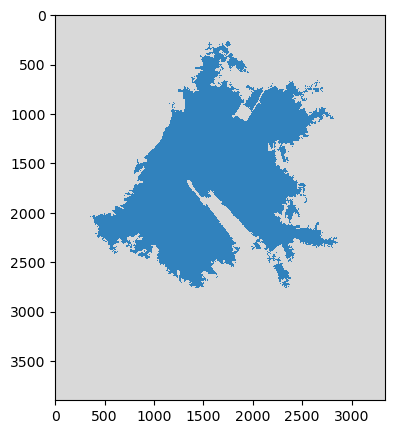

In [55]:
plt.figure(figsize=(5,5))
plt.imshow(regions2t, interpolation = 'none', cmap='tab20c_r')

In [56]:
regions2 = regions2t - holes2

In [57]:
print(regions2.max())
print(regions2.sum())

1
2765484


In [58]:
regions2_conn = skimage.measure.label(regions2, background=0, connectivity=2)

In [59]:
POPda=1 * np.ones_like(POP_da)*(POP_da.values>=0)*(POP_da.values)

In [60]:
unique2, counts2 = np.unique(regions2_conn, return_counts=True)   # background=0, 
print(unique2)
print()
print(counts2)

[0 1]

[10257734  2765484]


In [61]:
regs3 = [x for x in zip(unique2, counts2) if x[1] < counts2.max()]
print(len(regs3)), print()

label3=[]
area3=[]
pops3=[]

for reg3 in regs3:    
    regID3=1 * np.ones_like(POP_da)*(regions2_conn == reg3[0])    
    # regID3=(regions2_conn == reg3[0])
    popID3=regID3*POPda  
    label3.append(reg3[0])
    area3.append(regID3.sum())
    pops3.append(popID3.sum().round(0).astype(int))

1



In [62]:
attr = [x for x in zip(label3, area3, pops3)]
attr_df = pd.DataFrame(attr, columns=['label','area_pix','population'])
attr_df

,label,area_pix,population
0,1,2765484.0,1945008


In [63]:
attr_df.population.max()

1945008

#### numpy.ndarray to DataArray

In [64]:
UCE05 = xr.DataArray(
    data=regions2_conn,
    dims=POP_da.dims,
    coords=POP_da.coords,
    name='urban_centre',
    attrs=POP_da.attrs,
    )
UCE05

<xarray.DataArray 'urban_centre' (y: 3898, x: 3341)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 -63.3 -63.3 -63.3 -63.3 ... -63.0 -63.0 -63.0 -63.0
  * y            (y) float64 -17.65 -17.65 -17.65 -17.65 ... -18.0 -18.0 -18.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    grid_mapping:   spatial_ref

In [65]:
UCE05.values.max()

1

#### RASTER TO VECTOR : rasterio.features.shapes

In [66]:
# image dtype must be one of: int16, int32, uint8, uint16, float32
print(UCE05.dtype)
UCE05=UCE05.astype(np.int16)
UCE05.dtype

int64


dtype('int16')

In [67]:
from rasterio.features import shapes

# mask=None
mask=UCE05.data != 0
with UCE05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=8, transform=POP_da.rio.transform())))
    
# UCE05.rio.crs    , src.transform,  ccrs.Mollweide()

In [68]:
geoms = list(results)
# # first feature
# print(geoms[0])

In [69]:
# 
UCD  = gpd.GeoDataFrame.from_features(geoms)
UCD.tail(2)

,geometry,raster_val
0,"POLYGON ((-63.14222 -17.67310, -63.14213 -17.6...",1.0


#### Urban Centre Delineation

In [70]:
UCD=UCD.merge(attr_df, left_on='raster_val', right_on='label')
UCD.drop(columns=['raster_val'],inplace=True)
UCD=UCD.set_crs('EPSG:4326')

In [71]:
UCD=UCD[UCD['population']>=THR_UPP]
UCD

,geometry,label,area_pix,population
0,"POLYGON ((-63.14222 -17.67310, -63.14213 -17.6...",1,2765484.0,1945008


#### area (utm)

In [72]:
est_utm = AOI.centroid.estimate_utm_crs()

In [73]:
est_utm.to_epsg()

32720

In [74]:
# UCD['area_km2']
UCD['area_km2']=(UCD.to_crs(est_utm.to_epsg()).geometry.area/1000000).round(1)
UCD

,geometry,label,area_pix,population,area_km2
0,"POLYGON ((-63.14222 -17.67310, -63.14213 -17.6...",1,2765484.0,1945008,261.7


In [75]:
from datetime import datetime
# Generate a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2024-03-07_11-45-24'

In [76]:
# Export to geojson WGS84 (EPSG:4326 )
# AOI.centroid.x.round(2) ,  AOI.centroid.y.round(2)

UCD.to_file(os.path.join(output_dir,'UCD_EPSG4326' + '_' + str(country) + '_' + str(THR_UPA) + '_' + str(THR_UPP) + '_' + str(AOI.centroid.x.round(2)[0]) + '_' + str(AOI.centroid.y.round(2)[0]) + '_' + timestamp + '.geojson'), driver="GeoJSON")


UCD: export to vector

### view results in folium

In [77]:

fig = Figure(width=500, height=500)

m = AOI.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

lat_interval = 1
lon_interval = 1

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

UCD.explore(m=m,style_kwds={'fillColor':'red','color':'red','weight': 1.5}, name='Urban Centre')

folium.LayerControl('topright',collapsed=True).add_to(m)
minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
m.add_child(minimap)

fig.add_child(m)
m


# box(36.6,-1.4, 37.2 ,-1.05)

In [78]:

end_time = datetime.now().time().strftime('%H:%M:%S')
total_time=(datetime.strptime(end_time,'%H:%M:%S') - datetime.strptime(start_time,'%H:%M:%S'))
print('total time of running:', total_time)

total time of running: 0:02:07


In [79]:
print('total time of running:', total_time)

total time of running: 0:02:07
